# A mixture of motifs model reproduces the binding signature

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

import pyrepseq as prs
import pyrepseq.plotting as pp

plt.style.use('tcrspace.mplstyle')

In [2]:
# number of total sites
k = 6
# number of choices for specific binding
c = 3
# number of choices of aminoacids
q = 20

# Step 1: Generate background k-mer sequences using realistic aa usage frequencies

In [3]:
data_directory ='data/minervina/'
chain = 'alpha'
df_back = pd.read_csv(data_directory + '{chain}/W_F1_2018_{chain}.txt.gz'.format(chain=chain), sep='\t')
df_back = df_back[df_back['aaSeqCDR3'].apply(prs.isvalidcdr3)]    

In [4]:
def count_kmers(string, k, counter=None, gap=0):
    """
    Count occurrence of kmers in a given string.
    """
    if counter is None:
        counter = defaultdict(int)
    for i in range(len(string)-k-gap+1):
        if gap:
            counter[string[i]+string[i+gap+1:i+k+gap]] += 1
        else:
            counter[string[i:i+k]] += 1
    return counter

In [5]:
def count_kmers_iterable(iterable, k, clean=False, **kwargs):
    """
    Count number of kmers in all strings of an iterable
    """
    counter = defaultdict(int)
    for seq in iterable:
        count_kmers(seq, k, counter=counter, **kwargs)
    if clean:
        counter = {k:counter[k] for k in counter.keys() if isvalidaa(k)}
    return counter

In [6]:
aacounts = count_kmers_iterable(df_back['aaSeqCDR3'], 1)

In [7]:
aminoacids = list(aacounts.keys())
len(aminoacids)

20

In [8]:
weights = np.array(list(aacounts.values()),
                  dtype=np.float)
weights /= np.sum(weights)

In [9]:
num_seqs = int(2e7)
sequences = [''.join(row) for row in np.random.choice(list(aminoacids),
                                                     (num_seqs, k),
                                                     p=weights)]

In [10]:
bins = np.arange(0, k+2)
hist_back_norm = prs.pcDelta(sequences, bins=bins, maxseqs=10000)
hist_back_norm[0] = prs.pc(sequences)

# Step 2: Generate specific sequences according to a multi-motif selection model

In [11]:
def list_motif(*motif):
    return list(''.join(seq) for seq in itertools.product(*motif))

In [12]:
def simulate_binding(num_seqlogos, prng=np.random):
    specific_sequences = []
    for i in range(num_seqlogos):
        motif = [tuple(prng.choice(list(set(aminoacids)), size=c, replace=False))
                 for i in range(k)]
        specific_sequences.extend(list_motif(*motif))
    # find which of the background sequences is in the set of motif compatible sequences
    pd_sequences = pd.Series(sequences)
    sampled_sequences = np.array(pd_sequences[pd_sequences.isin(set(specific_sequences))])
    return sampled_sequences

In [13]:
num_seqlogoss = [1, 10, 50]
hist_norms = {}
prng = np.random.RandomState(12345)
for num_seqlogos in num_seqlogoss:
    sampled_sequences = simulate_binding(num_seqlogos, prng=prng)
    print(len(sampled_sequences))
    hist_norm = prs.pcDelta(sampled_sequences, bins=bins)
    hist_norms[num_seqlogos] = hist_norm

64
2033
11400


In [14]:
def pcratio_analytical(Delta, q, c, k, M):
    return 1.0/M * (q/c)**k * ((c-1.0)/(q-1.0))**Delta + 1 - 1.0/M

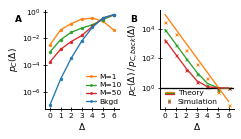

In [15]:
fig, axes = plt.subplots(figsize=(3.42, 2.0), ncols=2)

num_lines = []
for i, num_seqlogos in enumerate(num_seqlogoss):
    hist_norm = hist_norms[num_seqlogos]
    axes[0].plot(bins[:-1], hist_norm, 'o-', label='M={N}'.format(N=num_seqlogos), color=f'C{i+1}')
    l, = axes[1].plot(bins[:-1], hist_norm/hist_back_norm, 'x', ms=3, color=f'C{i+1}')
    num_lines.append(l)

axes[0].plot(bins[:-1], hist_back_norm, 'o-', label='Bkgd', color='C0')

axes[1].axhline(1.0, color='k')
Delta = bins[:-1]
analytical_lines = []
for i, num_seqlogos in enumerate(num_seqlogoss):
    l, = axes[1].plot(Delta, pcratio_analytical(Delta, q, c, k, num_seqlogos), '-',
            zorder=10, color=f'C{i+1}')
    analytical_lines.append(l)

axes[1].legend([tuple(analytical_lines), tuple(num_lines)], ['Theory', 'Simulation'],
               handler_map={tuple: pp.HandlerTupleOffset(horizontal=False)},
               loc='lower left', fontsize='small')

axes[0].set_ylabel('$p_C(\Delta)$')
axes[1].set_ylabel(r'$p_C(\Delta)\,/\,p_{C,back}(\Delta)$')
for ax in axes:
    ax.set_yscale('log')
    ax.set_xlabel('$\Delta$')
    ax.set_xlim(-0.5, k+0.5)
    ax.set_xticks(np.arange(k+1))
axes[0].legend(loc='lower right', bbox_to_anchor=(1.1, 0.0), fontsize='small')
fig.tight_layout(w_pad=0.0)
pp.label_axes(fig, xy=(-0.4, 0.95))
fig.savefig('figures/figure5.svg')